# This project is aimed on testing of a Bayesian Network text classification

In this project, we will use Fast Text pre-trained embeddings for encoding specific words with a consequent PCA dimensionality reduction

The approach above is used to encode a text and get a reasonable amount of features to feed in a Bayesian Network

The project is going to work with a Mongo Database from the [Peony project](https://github.com/sahanmar/Peony/tree/master/Peony_project/Peony_database)

### General Imports

In [1]:
import os
import pandas as pd
import numpy as np
import appdirs
import matplotlib.pyplot as plt

from torch import torch

from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc, precision_recall_curve

from pathlib import Path
from typing import List
from joblib import Memory

## Getting The Data and Encode Them

As written previously we will the data from Peony project. We will work with [Huffpost Dataset](https://www.kaggle.com/rmisra/news-category-dataset/home). The article texts were scraped from the links given in the dataset.

### Load Sports and Comedy datasets

In [2]:
from PeonyPackage.PeonyDb import MongoDb

In [3]:
api = MongoDb()
 
# Sports records
records_1 = api.get_record(
        collection_name="HuffPost_dataset",
        collection_id=1,
        label="SPORTS",
        limit=500,
    )

# Comedy records
records_2 = api.get_record(
        collection_name="HuffPost_dataset",
        collection_id=1,
        label="COMEDY",
        limit=500,
    )

# Stack records and labels with shuffling them
instances = records_1 + records_2
labels = [sample["record"]["label"] for sample in records_1 + records_2]
instances_from_db, labels_from_db = shuffle(instances, labels, random_state=0)

### Example of the Sport category text 

In [4]:
print("\n\033[1m",records_1[0]["record"]["text"]["title"],'\033[0m',"\n") # bold text title
print(records_1[0]["record"]["text"]["body"].strip()) # article body


 Muhammad Ali Calls For Iran To Release Jailed WaPo Reporter  

Boxing legend Muhammad Ali is lending his voice to call for the release of Jason Rezaian, a Washington Post reporter who has been detained in Iran since July 2014 for unclear reasons.
In a statement issued Thursday by the National Press Club, Ali called Rezaian "a man of peace and great faith, a man whose dedication and respect for the Iranian people is evident in his work."
Rezaian holds dual U.S.-Iranian citizenship and had been working in Iran as a journalist since 2008, before becoming the Post's Tehran correspondent in 2012. Rezaian and his wife, Yeganeh Salehi, were arrested on July 22. Salehi, also a Tehran-based journalist, was released on bail in October.
Rezaian's family has been pleading for his release and U.S. lawmakers last year urged Secretary of State John Kerry to "prioritize" Rezaian's case in nuclear negotiations with Iran.
Ali said it is his "great hope" that Iran will end Rezaian's "prolonged detentio

### Example of the Comedy category text 

In [5]:
print("\n\033[1m",records_2[1]["record"]["text"]["title"],'\033[0m',"\n") # bold text title
print(records_2[1]["record"]["text"]["body"].strip()) # article body


 Black Thursday  

"Christmas ain't Christmas till somebody cries," says Donkey, in Shrek the Halls.
It's only Thanksgiving and even now I'm searching for the box of tissues. I'm already stressed and I like my family. Most of the time.  
I'm trying to be grateful, even when my mom claims the chicken broth is vegetarian.
"Mom, there's a chicken on the box."
"That's just advertising..."
My brother interrupts, "Are you sure this is a tablespoon? I mean, it says tablespoon but I thought tablespoons were bigger."
My mom confirms the measurement and suggests he puts the mixer on low.
"I think I gotta do some more beating, first," he says.
I look at a crock pot on the table, an easily accessible weapon. I agree, friend, I agree.

I decide to leave homicide to the truly troubled and focus on being grateful. Fortunately, with the chaos comes their Griswold-style comedy that makes them so loveable (and great article fodder).
I'm grateful for my mom, who really just wants to be sure I'm getting 

### Fast Text Encoding

Fast Text model is a pre-trained model that works in a way of a hashmap where every word is assigned to a 300 component vector. The word corpus contains 1 million words and its pre-trained vectors. If there an unknown token in a text that has no vector representation it is assigned to a zero vector.

The theory behind Fast Text is covered [here](https://amitness.com/2020/06/fasttext-embeddings/). 

### Peony project encoding methods

[Peony](https://github.com/sahanmar/Peony) project has a complete implementation of text encoding. The encoding process is provided concerning a sentence. We split the text into sentences. Each sentence is split into word tokens. Sentence encoding is obtained as a mean value over all word embeddings for the sentence.

Text encoding proces is done as:

Text -> Sentence Split -> Word Tokens -> Words to vectors -> Word vectors mean over a sentnce -> Sentence vectors mean over a text

In [6]:
#change path to Peony project to get the classes for Fast Text embeddings
path = Path("../Peony/Peony_project")
os.chdir(path)

from Peony_box.src.transformators.HuffPost_transformator import (
    FastTextWordEmbeddings as transformator,
)

# Get a class to transform words to pretrained embeddings
HuffPostTransform = transformator()
HuffPostTransform.fit(instances_from_db, labels_from_db)

# Do the transformation
instances = HuffPostTransform.transform_instances(instances_from_db)
labels = HuffPostTransform.transform_labels(labels_from_db)

100%|██████████| 1000/1000 [00:00<00:00, 364405.21it/s]

transforming data...



  0%|          | 8/20207 [00:00<04:17, 78.53it/s]

creating (words -> embeddings) hash map...


100%|██████████| 1000/1000 [00:00<00:00, 622947.27it/s]


creating labels encoding hash map...


100%|██████████| 1000/1000 [00:00<00:00, 1536375.09it/s]


### Example of a text encoding

In [7]:
print(f"Size of the corpus is {len(instances)} texts")
print(f"Size of the first SHUFFLED text is {len(instances[0])} sentences")
# Sentence tokens are calculated as mean value through word tokens with respect to the sentence
print(f"Size of the all sentence tokens in texts is {len(instances[0][0])}")

Size of the corpus is 1000 texts
Size of the first SHUFFLED text is 4 sentences
Size of the all sentence tokens in texts is 300


### Text Encoding
Text encoding is done as a mean value of the sentence tokens through all sentences with respect to a text

In [8]:
encoded_instances = [torch.mean(torch.stack(instance),dim=0) for instance in instances]

### Dimensionality Reduction for Transfering features to a Bayesian Network

#### PCA dimensionality reduction

In this project different experiments with the optimal number of dimensions were tried. However, empirically it was found out that 7 components work the best!

In [9]:
# find the most important dimensions with respect to PCA algo and limit them to n_components dims
n_components = 7
pca = PCA(n_components=n_components)
pca.fit(torch.stack(encoded_instances))

PCA(n_components=7)

In [10]:
# Choose the most important dims with respect to our data
pca_encoded_instances = [pca.transform(instance.reshape(1,-1).detach().numpy())[0] for instance in encoded_instances]

## Data Discretization

The data are continuous. Thus, to have better discriminability and distribution estimates, we decided to provide data binning and rescale the data on the interval [0,1]

In [11]:
headers = [f"feature {i}" for i in range(n_components)]
df = pd.DataFrame(pca_encoded_instances)
df.columns = headers

#### Visualization of 10 rows of the pre-discretized table

In [12]:
df[:10]

,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6
0,-0.092985,0.024344,-0.085124,0.059167,-0.046396,-0.029808,-0.009088
1,0.010930,0.057846,-0.056320,-0.038864,-0.025616,0.020377,-0.032831
2,0.029804,0.045558,0.104484,0.025410,0.006001,0.081730,0.067939
3,0.007272,-0.014316,-0.030930,-0.002503,-0.031960,0.030446,0.011406
4,0.069869,0.208424,-0.215197,-0.140886,0.169987,0.071653,0.023002
5,0.123408,-0.078570,-0.064234,-0.029003,-0.024084,0.072318,-0.013226
6,-0.086955,0.024372,0.196306,-0.125876,-0.107484,-0.104929,-0.012064
7,-0.023052,0.083267,-0.023772,-0.018034,-0.013690,0.039793,-0.053288
8,-0.024671,0.037867,0.090773,0.017185,-0.019809,0.015853,0.043911
9,-0.130826,0.148558,-0.067179,0.145317,-0.108877,0.000320,-0.050817


In [13]:
def discretize_array(data: List[float], bins_num: int = 10) -> List[int]:
    max_val = max(data)
    min_val = min(data)
    bins = np.linspace(min_val, max_val, bins_num)
    digitized = np.digitize(data, bins)
    return digitized/bins_num

In [14]:
categorical_df = pd.DataFrame()
categorical_df["article"] = labels
for i in range(n_components):
    categorical_df[f"feature {i}"] = discretize_array(df[f"feature {i}"])

#### Visualization of 10 rows of the pre-descretized table

First column represents the data class, the rest show the features that will help us to provide a classification

In [15]:
categorical_df[:10]

,article,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6
0,1,0.1,0.3,0.3,0.5,0.4,0.2,0.4
1,1,0.2,0.3,0.4,0.3,0.4,0.3,0.3
2,0,0.2,0.3,0.7,0.4,0.5,0.4,0.6
3,1,0.2,0.2,0.4,0.4,0.4,0.3,0.4
4,1,0.3,0.4,0.1,0.1,0.7,0.4,0.5
5,1,0.3,0.2,0.4,0.3,0.4,0.4,0.4
6,0,0.1,0.3,0.9,0.1,0.3,0.1,0.4
7,0,0.2,0.3,0.4,0.3,0.5,0.4,0.3
8,0,0.2,0.3,0.7,0.4,0.4,0.3,0.5
9,1,0.1,0.4,0.4,0.7,0.3,0.3,0.3


### Train Test Split

In this project, we use 1000 data samples where 500 samples represent Sports and 500 samples represent Comedy categories. Sports category is represented as a category 1, Comedy category is represented as a category 0

Train/Test split ration = 0.5

In [16]:
split = 0.5
index_2_split = int(len(categorical_df)*split)
train_df = categorical_df[:index_2_split]
test_df = categorical_df[index_2_split:]

## Bayesian Network

### Structure estimation

Structure estimation is going to be done with the usage of Python libary [pgmpy](https://pgmpy.org)

In [17]:
cachedir = Path("/Users/mark/Documents/Git/Dandelion/cache")
memory = Memory(cachedir)

In [18]:
from pgmpy import estimators

def estimate_structure_hc(data, scoring_method, show_progress=True):
    Estimator = estimators.HillClimbSearch

    est = Estimator(data, scoring_method)

    # The estimated structure is cached because the estimation is computationally expensive.
    estimate_cached = memory.cache(Estimator.estimate, ignore=['show_progress'], verbose=0)
    return estimate_cached(est, scoring_method=scoring_method, show_progress=show_progress)

In [19]:
dag = estimate_structure_hc(train_df, estimators.BicScore(train_df))

  0%|          | 1/1000000 [00:00<79:09:14,  3.51it/s]


The structure of the network is extremely simple. The search of the optimal graph showed that the best structure has only one connection and other features are independent. 

<Axes:>

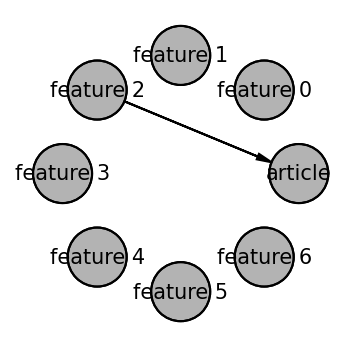

In [20]:
dag.to_daft(latex=False, node_pos='circular').render(150)

Based on the graph the architecture became simple with only one dependency. Thus, we can explicitly calculate the probabilities and create the model

### Probabilities Estimation

In [21]:
first_cat_counts = pd.DataFrame(train_df[train_df["article"] == 1]["feature 2"])
first_cat_counts["counts"] = [1]*len(first_cat_counts)

total_counts = pd.DataFrame(train_df["feature 2"])
total_counts["counts"] = [1]*len(total_counts)


first_cat_probs = round((first_cat_counts.groupby(first_cat_counts["feature 2"]).sum()
                   /total_counts.groupby(total_counts["feature 2"]).sum()).fillna(0),3)
first_cat_probs = first_cat_probs.reset_index()                   
first_cat_probs.columns = ["feature 2", "cat 1 probs"]

### Probabilities of Category 1 article with respect to feature 2

In [22]:
first_cat_probs

,feature 2,cat 1 probs
0,0.1,1.000
1,0.2,1.000
2,0.3,0.975
3,0.4,0.875
4,0.5,0.370
5,0.6,0.151
6,0.7,0.000
7,0.8,0.000
8,0.9,0.000
9,1.0,0.000


## Evaluation of Model

The model evaluation is provided with respect to Receiving Operating Characteristic (ROC), Area under ROC curve (AUC) and Precision-Recall (PR) curves

In [23]:
feature_2_to_probs_dict = {row["feature 2"]: row["cat 1 probs"] for _, row in first_cat_probs.iterrows()}

def roc_plot(fpr, tpr, auc, title):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color="darkorange",
             lw=lw, label="ROC curve (area = %0.2f)" % auc)
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
    
def prec_racall_plot(precision, recall, title):
    plt.figure()
    plt.step(recall, precision, where='post')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(title)

### Train Data

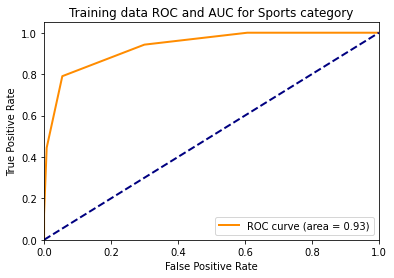

In [24]:
train_preds = [feature_2_to_probs_dict[row["feature 2"]] for _, row in train_df.iterrows()]
fpr, tpr, _ = roc_curve(train_df["article"], train_preds)
roc_auc = auc(fpr, tpr)
roc_plot(fpr,tpr,roc_auc, "Training data ROC and AUC for Sports category")

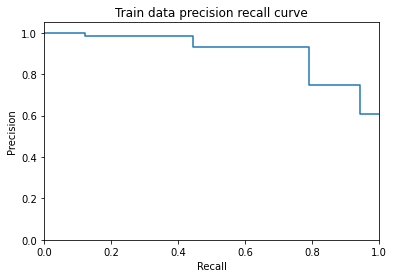

In [25]:
precision, recall, _ = precision_recall_curve(train_df["article"], train_preds)
prec_racall_plot(precision, recall, "Train data precision recall curve")

As seen from the plots, the model shows quite good classification results (0.93 AUC) with respect to the extremely simple structure and training data

### Test Data

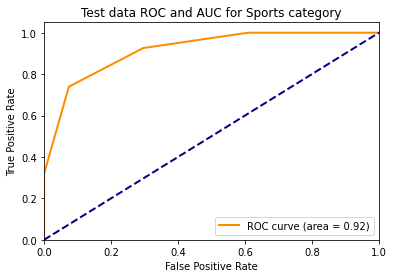

In [26]:
test_preds = [feature_2_to_probs_dict[row["feature 2"]] for _, row in test_df.iterrows()]
fpr, tpr, _ = roc_curve(test_df["article"], test_preds)
roc_auc = auc(fpr, tpr)
roc_plot(fpr,tpr,roc_auc, "Test data ROC and AUC for Sports category")

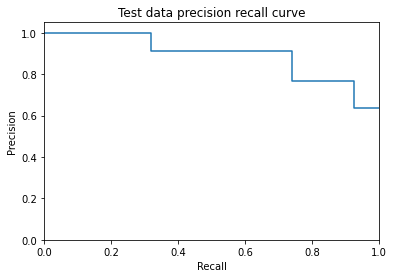

In [27]:
precision, recall, _ = precision_recall_curve(test_df["article"], test_preds)
prec_racall_plot(precision, recall, "Test data precision recall curve")

It is expected that the model will show slightly worse results on test data. However, the difference between training and testing stats is almost neglectable. Test data show classification stats as 0.92 AUC what is extremely good concerning such a simple model structure.